In [1]:
%run ../_preamble.ipynb
from _work.src.modules import AutoEncoder, train_model, plot_metrics, plot_tensor, eval_model, get_distances, get_closest_item
from _work.src.modules.replay import get_attractors, iterate
from _work.src.modules.utils import save_metrics, load_metrics
from _work.src.data import small_dataloader as dataloader
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

palette = {
    'Oak': '#B0E65A',
    'Pine': '#75993C',
    'Daisy': '#FEB756',
    'Rose': '#E6634E',
    'Salmon': '#9194E3',
    'Sunfish': '#8BCBD9',
    'Canary': '#FFD92F',
    'Robin': '#FF8C9A',
}

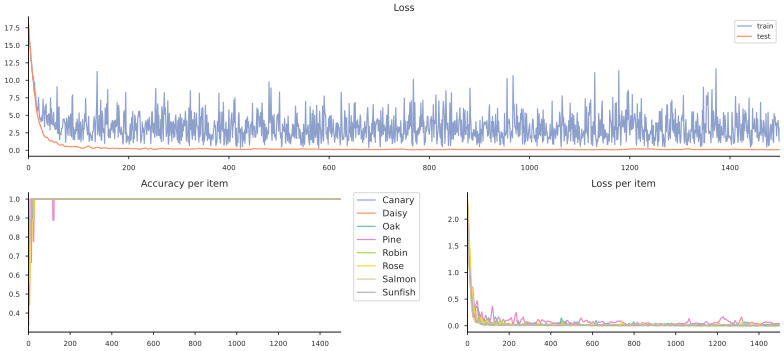

In [2]:
metrics1 = train_model(
    model1 := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32], batch_norm=False, dropout=0),
    optimizer1 := torch.optim.AdamW(model1.parameters(), lr=1e-2),
    loss_fn1 := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=1500,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
    l1_lambda=0.0005,
)

plot_metrics(metrics1);

In [41]:
from _work.src.modules.utils import round_tensor
from torch.autograd.functional import jacobian

@torch.no_grad()
def get_fixed_points(model, initial_state_fn=None, n_runs=500, n_steps=100, min_occurrence=1, return_counts=False):
    model.eval()

    fixed_points = []
    for _ in range(n_runs):
        x = torch.randn(9) if initial_state_fn is None else initial_state_fn()
        for _ in range(n_steps):
            y = model(x)
            if torch.allclose(x, y, atol=1e-10, rtol=1e-7):
                fixed_points.append(x)
                break
            x = y
    
    fixed_points = torch.vstack(fixed_points)
    uniqs, indices, counts = torch.unique(
        round_tensor(fixed_points, decimals=3),
        dim=0,
        return_inverse=True,
        return_counts=True,
    )
    t = [[] for _ in indices.unique()]
    for i, j in enumerate(indices):
        t[j].append(fixed_points[i])
    t = [torch.vstack(x).mean(dim=0) for x in t]
    
    mask = counts > min_occurrence
    counts = counts[mask, ...]
    points = torch.vstack(t)[mask, ...]
    sorted_points = torch.vstack([x for _, x in sorted(zip(counts, points), key=lambda x: x[0], reverse=True)])

    if return_counts is True:
        return sorted_points, [x.item() for x in sorted(counts, reverse=True)]
    
    return sorted_points


def get_jacobian(model, fixed_point, it=1):
    model.eval()

    is_fixed_point = torch.allclose(model(fixed_point), fixed_point, atol=0.05)
    assert is_fixed_point

    def f(*args):
        x = torch.vstack(args)
        for _ in range(it):
            y = model(x)
            x = y
        return y

    return jacobian(f, fixed_point)


def is_attractor(model, fixed_point):
    j = get_jacobian(model, fixed_point)
    m = j.abs().max()
    return (m < 1).item()

tensor(1.6414e-10) tensor(-7.2986e-19)
tensor(6.1828e-09) tensor(-1.6604e-16)
tensor(3.3197e-08) tensor(-1.9650e-17)
tensor(0.0007) tensor(-7.2626e-12)
tensor(7.6704e-07) tensor(-7.1307e-15)
tensor(0.0097) tensor(-1.6000e-10)


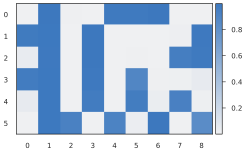

In [40]:
pts = get_fixed_points(model1, n_runs=1000, n_steps=250)
plot_tensor(pts);

for pt in pts:
    j = get_jacobian(model1, pt).squeeze()
    eigv = torch.eig(j)[0][:, 0]
    print(eigv.max(), eigv.min())

tensor(1.2812e-05) tensor(-2.8724e-13)
tensor(7.8631e-05) tensor(-1.7789e-12)
tensor(0.0002) tensor(-7.1099e-13)
tensor(0.0009) tensor(-5.6047e-12)
tensor(0.0256) tensor(-2.2362e-10)
tensor(0.0983) tensor(-2.2482e-11)


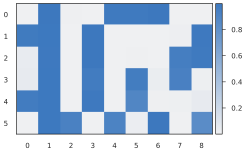

In [38]:
pts = get_fixed_points(model1, n_runs=1000, n_steps=250)
plot_tensor(pts);

for pt in pts:
    j = get_jacobian(model1, pt).squeeze()
    eigv = torch.eig(j)[0][:, 0]
    print(eigv.max(), eigv.min())

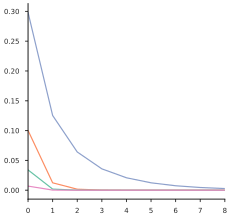

In [57]:
e = []
for it in range(1, 10):    
    eigs = torch.vstack([torch.eig(get_jacobian(model1, x, it=it).squeeze())[0][:, 0] for x in pts])
    means = eigs.mean(dim=0)
    e.append(means)
e = torch.vstack(e)
# print(e[:, 0])
plt.plot(e[:, 0]);
plt.plot(e[:, 1]);
plt.plot(e[:, 2]);
plt.plot(e[:, 3]);

In [19]:
def generate_patterns(model, n_runs=1, n_steps=10, take_last=1, mean=0, stdev=1, multiplier=1):
    assert take_last <= n_steps

    states, _ = iterate(model, runs=n_runs, steps=n_steps, mean=mean, stdev=stdev, multiplier=multiplier)
    states = torch.vstack(tuple(states[:, -take_last:, :]))

    return states # n_runs * take_last

def create_dataloaders(states, n_epochs):
    class ReplayDataset(Dataset):
        def __init__(self, data):
            super().__init__()
            self.data = data
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, i):
            return {
                'y': self.data[i],
            }

    dataloaders = []
    for _ in range(n_epochs):
        indices = np.random.choice(list(range(len(states))), size=8, replace=False)
        data = ReplayDataset(states[indices])
        dl = DataLoader(data, shuffle=True, batch_size=4)
        dataloaders.append(dl)
    
    return dataloaders

In [117]:
noisy_patterns = generate_patterns(
    model1,
    n_runs=1000,
    n_steps=20,
    take_last=1,
    mean=0,
    stdev=1,
    multiplier=0.2,
)

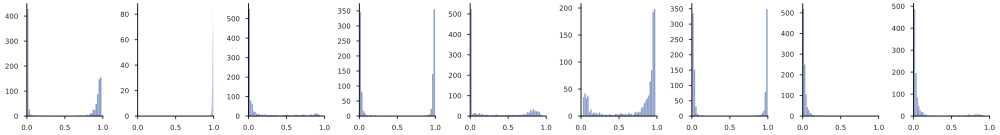

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(14, 2))
for i in range(9):
    hist, edges = np.histogram(noisy_patterns[:, i], bins=50)
    axes[i].bar(edges[:-1], hist, width=np.diff(edges), align="edge")
    axes[i].set_xlim([0, 1])
plt.tight_layout()

In [119]:
patterns = generate_patterns(
    model1,
    n_runs=1000,
    n_steps=20,
    take_last=1,
    mean=None,
    stdev=None,
    multiplier=0.2,
)

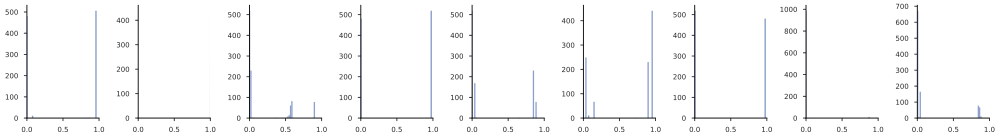

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(14, 2))
for i in range(9):
    hist, edges = np.histogram(patterns[:, i], bins=50)
    axes[i].bar(edges[:-1], hist, width=np.diff(edges))
    axes[i].set_xlim([0, 1])
plt.tight_layout()

In [132]:
from sklearn.decomposition import PCA
from matplotlib import colors

@plt.style.context({ 'axes.xmargin': 0.05 })
def plot_patterns(A, B):
    pca = PCA(n_components=2)
    pca.fit(torch.cat((A, B), dim=0))

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7, 2))
    for i, x in enumerate([A, B]):
        X = pca.transform(x)

        classes = []
        for pattern in x:
            items = get_distances(pattern, dataloader.dataset.df, metric='euclidean')
            closest_item = items[0][0]
            classes.append(closest_item)
        things = [*palette.keys()]
        classes = [things.index(x) for x in classes]
        cmap = colors.ListedColormap([*palette.values()])

        axes[i].scatter(X[:, 0], X[:, 1], c=classes, cmap=cmap)

n_patterns = 5000
n_steps = 50
last = 5
plot_patterns(
    generate_patterns(
        model1,
        n_runs=n_patterns,
        n_steps=n_steps,
        take_last=last,
        mean=None,
        stdev=None,
        multiplier=0.2,
    ),
    generate_patterns(
        model1,
        n_runs=n_patterns,
        n_steps=n_steps,
        take_last=last,
        mean=0,
        stdev=1,
        multiplier=0.1,
    ),
)